# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import findspark
sns.set()

from pyspark.sql import *
%matplotlib inline
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import desc
import pyspark.sql.functions as function
spark = SparkSession.builder.getOrCreate()

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [2]:
# Let's load the json file into a spark dataframe
df = spark.read.json("Posts.json")
df.show(10)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|         2|    0|                null|                null|     null|
|2010-10-26T03:20:...|4020443| 4020419|         2|  324|                null|                null|     null|
|2010-10-26T03:20:...|4020444| 4020433|         2|    0|                null|                null|     null|
|2010-10-26T03:21:.

In [3]:
# Check the size of the dataset
df.count()

40839832

In [4]:
# Check the type of each attribute in the dataframe
df.dtypes

[('CreationDate', 'string'),
 ('Id', 'bigint'),
 ('ParentId', 'bigint'),
 ('PostTypeId', 'bigint'),
 ('Score', 'bigint'),
 ('Tags', 'string'),
 ('Title', 'string'),
 ('ViewCount', 'bigint')]

In [5]:
# Check if there is any datapoint that is not a question nor an answer
df.groupby('PostTypeId').count().show()

+----------+--------+
|PostTypeId|   count|
+----------+--------+
|         1|15647060|
|         2|25192772|
+----------+--------+



In [7]:
#We filter the dataset based on the PostTypeId to calculate the total number of questions an answers.
num_questions = df.where("PostTypeId=1").count() # same as df.rdd.filter(lambda r: r[3] == 1).count()
num_answers = df.where("PostTypeId=2").count()# same as df.rdd.filter(lambda r: r[3] == 2).count()
num_total = df.count()
print('The number of questions in the dataset is %d out of a total of %d.'%(num_questions,num_total))
print('The number of answers in the dataset is %d out of a total of %d.'%(num_answers,num_total))
assert(num_total == num_questions+num_answers)
print('The total number of rows is coherent with the number of questions and answers.')
# We add the condition of 0 score in the filtering
num_ques_0 = df.where((col("PostTypeId")==1) & (col("Score")==0)).count() #same as df.rdd.filter(lambda r: r[3] == 1 and r[4]==0).count()
print('The percentage of questions with 0 score is %f%%.' %(num_ques_0*100/num_total))

The number of questions in the dataset is 15647060 out of a total of 40839832.
The number of answers in the dataset is 25192772 out of a total of 40839832.
The total number of rows is coherent with the number of questions and answers.
The percentage of questions with 0 score is 17.832380%.


In [8]:
#Checkout the format of the timestamps before converting them
df.select('CreationDate').show(10,False)

+-----------------------------+
|CreationDate                 |
+-----------------------------+
|2010-10-26T03:17:55.603+02:00|
|2010-10-26T03:18:17.873+02:00|
|2010-10-26T03:19:05.063+02:00|
|2010-10-26T03:19:33.530+02:00|
|2010-10-26T03:20:12.940+02:00|
|2010-10-26T03:20:22.687+02:00|
|2010-10-26T03:21:12.657+02:00|
|2010-10-26T03:21:40.893+02:00|
|2010-10-26T03:21:42.413+02:00|
|2010-10-26T03:21:46.280+02:00|
+-----------------------------+
only showing top 10 rows



In [9]:
# Converting time to datetimes
def convert_time(string):
    return parse(string)

# df is a spark dataframe containing all data after filtering and arranging time.
# We also discard the column with corrupt data
df = df.rdd.map(lambda r: Row(Time=convert_time(r[0]),Id=r[1],ParentId=r[2],PostTypeId=r[3],Score=r[4],
                                     Tags=r[5],Title=r[6],ViewCount=r[7])).toDF()
df.show(10)

+-------+--------+----------+-----+--------------------+--------------------+--------------------+---------+
|     Id|ParentId|PostTypeId|Score|                Tags|                Time|               Title|ViewCount|
+-------+--------+----------+-----+--------------------+--------------------+--------------------+---------+
|4020437|    null|         1|    0|<asp.net-mvc><jqu...|2010-10-26 03:17:...|display jquery di...|      510|
|4020438|    null|         1|    0|<javascript><html...|2010-10-26 03:18:...|Why can only my m...|       62|
|4020440| 4020214|         2|    1|                null|2010-10-26 03:19:...|                null|     null|
|4020441| 3938154|         2|    0|                null|2010-10-26 03:19:...|                null|     null|
|4020443| 4020419|         2|  324|                null|2010-10-26 03:20:...|                null|     null|
|4020444| 4020433|         2|    0|                null|2010-10-26 03:20:...|                null|     null|
|4020445|    null| 

In [ ]:
#Let's now transform the spark dataframe to a Parquet format
df.write.parquet("df.parquet")

**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

## 1. What is the proportion of tags that appear in fewer than 100 questions?

In [10]:
#Clear memory to avoid overload
%reset -f 
# If executed, you need to import the libraries/packages again
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import findspark
sns.set()

from pyspark.sql import *
%matplotlib inline
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import split, explode, udf
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import desc
import pyspark.sql.functions as function
spark = SparkSession.builder.getOrCreate()

In [11]:
# Load the dataset from the Parquet file
df =spark.read.parquet("df.parquet")

In [12]:
df.count()

40839832

In [13]:
# Let's checkout the Tags column and see their format.
df.select('Tags').show(10,False)

+-----------------------------------+
|Tags                               |
+-----------------------------------+
|null                               |
|null                               |
|<flash><react-native>              |
|null                               |
|null                               |
|null                               |
|<postgresql><formatting><plpgsql>  |
|null                               |
|<python><websocket><python-asyncio>|
|null                               |
+-----------------------------------+
only showing top 10 rows



In [14]:
# drop all rows where we don't have no tags since we're concerned by the questions tags.
df_questions = df.where(col("Tags").isNotNull())
# assert that all the rows in the df_questions dataframe are questions
assert(df_questions.where("PostTypeId=1").count()==df_questions.count())
df_questions.show(10,False)

+--------+--------+----------+-----+-------------------------------------------------------------------------+-----------------------+------------------------------------------------------------------------------------------+---------+
|Id      |ParentId|PostTypeId|Score|Tags                                                                     |Time                   |Title                                                                                     |ViewCount|
+--------+--------+----------+-----+-------------------------------------------------------------------------+-----------------------+------------------------------------------------------------------------------------------+---------+
|45740348|null    |1         |2    |<flash><react-native>                                                    |2017-08-17 16:20:28.873|Is it possible to embed Adobe flash into a react-native app?                              |143      |
|45740355|null    |1         |1    |<postgresql><formatt

In [15]:
# Since the dataframe with tags exploded to rows is needed in the next questions, it makes sense to create a function
# to do just that
def align_tags(df):
    # drop all rows where we don't have no tags since we're concerned by the questions tags.
    df_questions = df.where(col("Tags").isNotNull())
    df_aligned = df_questions.withColumn('Tags_aligned',explode(split('Tags','><')))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", "<", ""))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", ">", ""))
    return df_aligned

In [16]:
# Based on the snippet of the tags, we have to seperate each tag from the same column and remove the extra caracters < and >.
# It's easy to see that each tag string is between <> so we split them, put them in different rows and
# then remove extra caracters.
# We groupby based on the Tags name and the output is then sorted for convenience and transformed 
# to a pandas dataframe for further processing.

df_aligned = align_tags(df)
tags_df = df_aligned.groupBy(['Tags_aligned']).count().sort(desc("count")).toPandas()

# We also implemented the same method using RDD but we prefer using the dataframe API since it's faster.

#tags_df = df.withColumn('col4',explode(split('Tags','><')))\
#.rdd.map(lambda r: r[9].translate({ord(i):None for i in '<>'})).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)\
#.sortBy(lambda r: r[1], ascending = False).toDF().toPandas()

In [17]:
tags_df.columns=['Tags_aligned','Count']

In [18]:
fewer_than_100_df = tags_df[tags_df['Count']<100].reset_index(drop=True)
fewer_than_100_percentage = len(fewer_than_100_df)*100/len(tags_df)
print('The percentage of tags that show up in less than a 100 questions is %f%% '%(fewer_than_100_percentage))

The percentage of tags that show up in less than a 100 questions is 67.979394% 


In [19]:
tags_df.head(10)

,Tags_aligned,Count
0,javascript,1585495
1,java,1352735
2,c#,1172492
3,php,1136082
4,android,1088811
5,python,954401
6,jquery,886982
7,html,725289
8,ios,551843
9,c++,536267


In [ ]:
# We wanted to save the dataframe with exploded tags in a parquet format but we always get memory limit problems.

## 2. Plot the distribution of the tag counts using an appropriate representation.

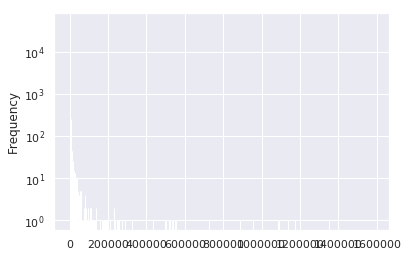

In [25]:
# log scale because there are only a few tags with very large counts
bins= np.arange(0,1586000,1000)
tags_df.Count.plot(kind='hist',bins =bins,log = True)
plt.show()

## 3. Plot a bar chart with the number of questions for the 10 most popular tags.

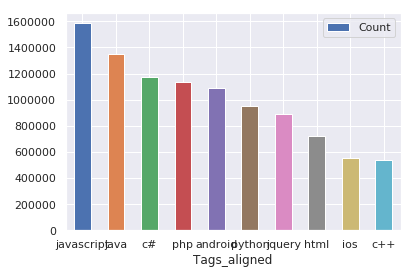

In [26]:
# Since our dataframe is already sorted, we can just take the first 10 rows to get the number of questions (counts) 
# for the most popular tags
tags_df[:10].plot.bar(x='Tags_aligned',y='Count',rot=0)
plt.show()

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

*Solution Task C*

In [27]:
# If memory is overloaded, you can load erase the variables, load the libraries and 'df_aligned.parquet' 
# which is the dataset with one tag per row

#Clear memory to avoid overload
%reset -f 
# If executed, you need to import the libraries/packages again
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import findspark
sns.set()

from pyspark.sql import *
%matplotlib inline
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import split, explode, udf
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import desc
import pyspark.sql.functions as function
spark = SparkSession.builder.getOrCreate()

# Since the dataframe with tags exploded to rows is needed in the next questions, it makes sense to create a function
# to do just that
def align_tags(df):
    # drop all rows where we don't have no tags since we're concerned by the questions tags.
    df_questions = df.where(col("Tags").isNotNull())
    df_aligned = df_questions.withColumn('Tags_aligned',explode(split('Tags','><')))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", "<", ""))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", ">", ""))
    return df_aligned

In [28]:
# Load the dataset from the Parquet file
df =spark.read.parquet("df.parquet")
# Put every tag in a new row
df_aligned = align_tags(df)

In [29]:
# We use the spark dataframe with the aligned tags to extract the columns we need
df_newtags_ = df_aligned.select(['ViewCount', 'Score', 'Tags_aligned', 'PostTypeId'])
df_newtags_.show()

+---------+-----+--------------------+----------+
|ViewCount|Score|        Tags_aligned|PostTypeId|
+---------+-----+--------------------+----------+
|      143|    2|               flash|         1|
|      143|    2|        react-native|         1|
|      444|    1|          postgresql|         1|
|      444|    1|          formatting|         1|
|      444|    1|             plpgsql|         1|
|      280|    0|              python|         1|
|      280|    0|           websocket|         1|
|      280|    0|      python-asyncio|         1|
|       97|    0|            facebook|         1|
|       97|    0|facebook-javascri...|         1|
|       97|    0|               share|         1|
|       97|    0|  facebook-opengraph|         1|
|       97|    0|           opengraph|         1|
|      185|    1|             mongodb|         1|
|      185|    1|               shell|         1|
|      327|    0|              impala|         1|
|       68|    1|                java|         1|


In [30]:
# Filter the dataframe to get only rows with the tag random-effects and convert to pandas df for viz
re_df = df_newtags_.where(df_newtags_.Tags_aligned=="random-effects").toPandas()
re_df.head()

,ViewCount,Score,Tags_aligned,PostTypeId
0,12,0,random-effects,1
1,495,0,random-effects,1
2,220,0,random-effects,1
3,21,0,random-effects,1
4,126,5,random-effects,1


In [31]:
# Number of questions with the tag random-effects
len(re_df)

100

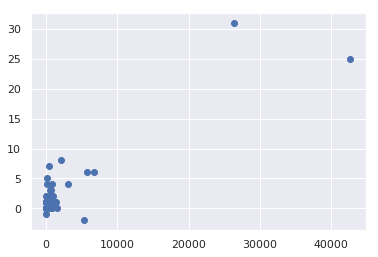

In [32]:
# Visualize relationship between these two variables
x = re_df.ViewCount.values
y = re_df.Score.values
ax = plt.figure()
plt.scatter(x, y) # s=2, c=2, alpha=0.5
#plt.xlim(-1000,10000)
#plt.ylim(-10,10)
plt.show()

In [33]:
# remove outlier
df_newtags_pd_out = re_df.copy()
df_newtags_pd_out['ViewCount'] = df_newtags_pd_out[df_newtags_pd_out['ViewCount'] < 20000]['ViewCount']
df_newtags_pd_out = df_newtags_pd_out.dropna()

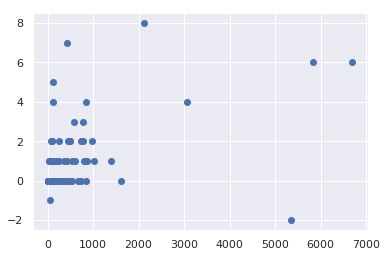

In [34]:
# Visualize relationship between these two variables
x = df_newtags_pd_out.ViewCount.values
y = df_newtags_pd_out.Score.values
ax = plt.figure()
plt.scatter(x, y) # s=2, c=2, alpha=0.5
#plt.xlim(-1000,10000)
#plt.ylim(-10,10)
plt.show()

In [35]:
# Evaluation of the correlation
import scipy
from scipy import stats
scipy.stats.pearsonr(x, y)

(0.4393894600749448, 6.000994687565495e-06)

In [36]:
np.corrcoef(x,y)

array([[1.        , 0.43938946],
       [0.43938946, 1.        ]])

In [ ]:
# pearson should apply to normal distrbs, check distribs for viewcount and score
# pearson coeff is 0.43 which means it's not linear but there is a correlation

very low relationship - (with outlier very high) 

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


Task D - 1

In [2]:
# Add your imports here
# If memory is overloaded, you can load erase the variables, load the libraries and 'df_aligned.parquet' 
# which is the dataset with one tag per row

#Clear memory to avoid overload
%reset -f 
# If executed, you need to import the libraries/packages again
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import findspark
sns.set()

from pyspark.sql import *
%matplotlib inline
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import split, explode, udf
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import desc
import pyspark.sql.functions as function
spark = SparkSession.builder.getOrCreate()

# Since the dataframe with tags exploded to rows is needed in the next questions, it makes sense to create a function
# to do just that
def align_tags(df):
    # drop all rows where we don't have no tags since we're concerned by the questions tags.
    df_questions = df.where(col("Tags").isNotNull())
    df_aligned = df_questions.withColumn('Tags_aligned',explode(split('Tags','><')))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", "<", ""))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", ">", ""))
    return df_aligned

In [3]:
# Load the dataset from the Parquet file
df = spark.read.parquet("df.parquet")
# Put every tag in a new row
df_aligned = align_tags(df)

In [4]:
# Get the answers:
df_time_answer = df.where(col("ParentId").isNotNull())

In [5]:
df_time_questions = df_aligned.select(['Tags_aligned', 'Id', 'Time', 'PostTypeId'])
df_time_questions.show(2)

+------------+--------+--------------------+----------+
|Tags_aligned|      Id|                Time|PostTypeId|
+------------+--------+--------------------+----------+
|       flash|45740348|2017-08-17 16:20:...|         1|
|react-native|45740348|2017-08-17 16:20:...|         1|
+------------+--------+--------------------+----------+
only showing top 2 rows



In [41]:
df_time_questions.count() # Number of questions

46684801

In [42]:
df_time_questions.select("Id").distinct().count() # each question Id is unique

15647060

In [43]:
df_time_answer.select("ParentId").distinct().count() # This is the number of question for which we have at least one answer

14186282

In [44]:
df_time_answer.count() # number of answers

25192772

In [45]:
# For the answers I select the column I need
df_time_answer = df_time_answer.select([col('Time').alias('answer_time'), 'PostTypeId', 'ParentId'])#, 'Time', 'Id', 'ParentId','PostTypeId'])
df_time_answer.show(5)

+--------------------+----------+--------+
|         answer_time|PostTypeId|ParentId|
+--------------------+----------+--------+
|2017-08-17 16:20:...|         2|45740224|
|2017-08-17 16:20:...|         2|45739185|
|2017-08-17 16:20:...|         2|45739102|
|2017-08-17 16:20:...|         2|42473616|
|2017-08-17 16:20:...|         2|45668191|
+--------------------+----------+--------+
only showing top 5 rows



Once we have obtained the spark dataframe (let's call it df), we will procede in the following way: 
<br>
1- For the questions dataframe filter all the rows according to ta "Java" and the "Python" tags<br>
2- Select all the questions in a pandas dataframe, saving the corresponding data (*Time*) and *Id* <br>
3- From the answers spark dataframe select all the first answers with the Ids corresponding to the list of Ids of the questions<br>
5- Compute time difference 

In [46]:
# 1- Filter all the rows of the questions according to the "Java" and the "Python" tags and  
df_time_questions_py_rdd = df_time_questions.rdd.filter(lambda r: r[0] == "python")
df_time_questions_jv_rdd = df_time_questions.rdd.filter(lambda r: r[0] == "java")

In [47]:
# Convert the RDD into a dataframe
df_time_questions_py_df = df_time_questions_py_rdd.toDF()
df_time_questions_jv_df = df_time_questions_jv_rdd.toDF()

In [48]:
# take intersection of question and answers dataframe based on ids which gives the dataframe containing
# answers for every question
df_time_answer_filter_py =df_time_answer.join(df_time_questions_py_df, df_time_answer.ParentId ==
                                              df_time_questions_py_df.Id, 'inner')

# for java tag
df_time_answer_filter_jv =df_time_answer.join(df_time_questions_jv_df, df_time_answer.ParentId == 
                                              df_time_questions_jv_df.Id, 'inner')

In [49]:
df_time_answer_filter_py.show(5)

+--------------------+----------+--------+------------+-----+--------------------+----------+
|         answer_time|PostTypeId|ParentId|Tags_aligned|   Id|                Time|PostTypeId|
+--------------------+----------+--------+------------+-----+--------------------+----------+
|2012-03-29 02:52:...|         2|   39104|      python|39104|2008-09-02 09:40:...|         1|
|2008-09-02 11:43:...|         2|   39104|      python|39104|2008-09-02 09:40:...|         1|
|2008-09-02 14:26:...|         2|   39104|      python|39104|2008-09-02 09:40:...|         1|
|2008-09-18 15:06:...|         2|   92620|      python|92620|2008-09-18 13:41:...|         1|
|2008-09-18 15:06:...|         2|   92620|      python|92620|2008-09-18 13:41:...|         1|
+--------------------+----------+--------+------------+-----+--------------------+----------+
only showing top 5 rows



In [50]:
# calculate the response time for python tagged
resp_time_py = unix_timestamp(df_time_answer_filter_py.answer_time) - unix_timestamp(df_time_answer_filter_py.Time)

#for java tag
resp_time_jv = unix_timestamp(df_time_answer_filter_jv.answer_time) - unix_timestamp(df_time_answer_filter_jv.Time)

In [51]:
# add response time column for python tag
df_time_answer_filter_py = df_time_answer_filter_py.withColumn('response_time' , resp_time_py)
df_time_answer_filter_py.show(3)

+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
|         answer_time|PostTypeId|ParentId|Tags_aligned|   Id|                Time|PostTypeId|response_time|
+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
|2012-03-29 02:52:...|         2|   39104|      python|39104|2008-09-02 09:40:...|         1|    112641136|
|2008-09-02 11:43:...|         2|   39104|      python|39104|2008-09-02 09:40:...|         1|         7399|
|2008-09-02 14:26:...|         2|   39104|      python|39104|2008-09-02 09:40:...|         1|        17141|
+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
only showing top 3 rows



In [52]:
# add response time column for java tag
df_time_answer_filter_jv = df_time_answer_filter_jv.withColumn('response_time' , resp_time_jv)
df_time_answer_filter_jv.show(3)

+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
|         answer_time|PostTypeId|ParentId|Tags_aligned|   Id|                Time|PostTypeId|response_time|
+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
|2008-12-21 00:07:...|         2|   30428|        java|30428|2008-08-27 15:21:...|         1|      9971142|
|2008-10-29 17:56:...|         2|   30428|        java|30428|2008-08-27 15:21:...|         1|      5456073|
|2008-11-11 03:00:...|         2|   30428|        java|30428|2008-08-27 15:21:...|         1|      6525566|
+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
only showing top 3 rows



In [53]:
# minimum  represents quickest response out of all responses
min_time_py = df_time_answer_filter_py.groupby('ParentId').agg({'response_time' : 'min'})
min_time_py.show(3)

+--------+------------------+
|ParentId|min(response_time)|
+--------+------------------+
|   39104|              7399|
|   92620|              5089|
|  116139|               511|
+--------+------------------+
only showing top 3 rows



In [54]:
# minimum  represents quickest response out of all responses
min_time_jv = df_time_answer_filter_jv.groupby('ParentId').agg({'response_time' : 'min'})
min_time_jv.show(3)

+--------+------------------+
|ParentId|min(response_time)|
+--------+------------------+
|   30428|              1922|
|   37310|               439|
|   55709|               290|
+--------+------------------+
only showing top 3 rows



In [55]:
python_resp_pd = min_time_py.toPandas() 
java_resp_pd = min_time_jv.toPandas()

D - 2
Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.

In [56]:
python_resp_pd.describe()

,ParentId,min(response_time)
count,8.301600e+05,8.301600e+05
mean,3.109707e+07,9.808257e+05
std,1.454786e+07,6.900002e+06
min,4.690000e+02,-1.052941e+08
25%,1.974593e+07,4.220000e+02
50%,3.324952e+07,1.347000e+03
75%,4.387570e+07,9.496000e+03
max,5.213415e+07,2.464575e+08


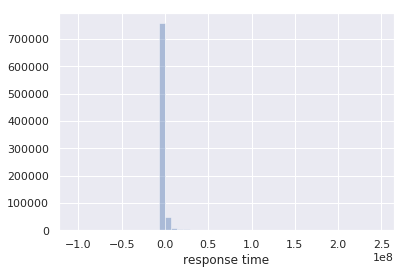

In [64]:
sns.distplot(python_resp_pd.iloc[:,1], bins=50, axlabel = 'response time',kde=False)

In [65]:
java_resp_pd.describe()

,ParentId,min(response_time)
count,1.179070e+06,1.179070e+06
mean,2.581939e+07,9.966370e+05
std,1.417118e+07,7.127989e+06
min,1.230000e+02,-9.986573e+07
25%,1.382513e+07,3.940000e+02
50%,2.571343e+07,1.218000e+03
75%,3.732461e+07,9.552000e+03
max,5.213414e+07,2.985367e+08


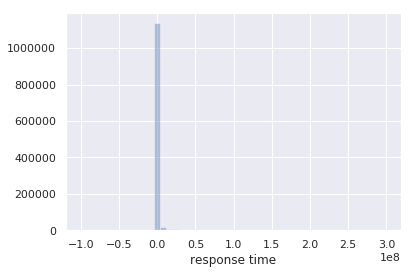

In [68]:
sns.distplot(java_resp_pd.iloc[:,1],bins=50, axlabel = 'response time', kde = False)

We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.

In [69]:
df_time_answer_filter_py.show(1)

+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
|         answer_time|PostTypeId|ParentId|Tags_aligned|   Id|                Time|PostTypeId|response_time|
+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
|2012-03-29 02:52:...|         2|   39104|      python|39104|2008-09-02 09:40:...|         1|    112641136|
+--------------------+----------+--------+------------+-----+--------------------+----------+-------------+
only showing top 1 row



In [70]:
df_time_answer_filter_py.select('response_time').sample(True,0.9999,2)

DataFrame[response_time: bigint]

In [71]:
mean = df_time_answer_filter_py.groupby().avg('response_time').collect()

In [2]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
def bootstrap(df):
    means = []
    lower_bound_ci = []
    upper_bound_ci = []
    for i in range(2):
        df = df.sample(True,fraction=0.9999,seed=7)
        sample_size = df.count()
        
        df_stats = df.select(_mean(col('response_time')).alias('mean'),
                             _stddev(col('response_time')).alias('std')).collect()
        mean = df_stats[0]['mean']
        std = df_stats[0]['std']
        
        x1 = mean - 1.96*std/sample_size  #follows normal distribution since sample size is very large(central limit theorem)
        x2 = mean - 1.96*std/sample_size  #for cI = 95%, z=1.96 from above assumption
    
    lower_bound_ci.append(x1) 
    upper_bound_ci.append(x2)
    means.append(mean)
    return means, lower_bound_ci, upper_bound_ci

In [ ]:
means_py,l1,l2 = bootstrap(min_time_py.select('min(response_time').alias('response_time'))
#means_jv = bootstrap(min_time_jv.select('response_time'))

In [74]:
sns.boxplot(means_py)

NameError: name 'means_py' is not defined

In [ ]:
sns.boxplot(means_jv)

Conclude here about the boxplots and whether python response time is lower

Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.

In [ ]:
df_time_questions = df_time_questions.groupby('newTags'.'ParentId').count().withColumnRenamed('count','cnt')                                                                            

In [ ]:
df_time_questions.show(4)

In [ ]:
df_time_questions = df_time_questions.filter(df_time_questions.cnt > 5000)

In [ ]:
# take intersection of question and answers dataframe based on ids which gives the dataframe containing
# answers for every questions
df_time_answer_filter =df_time_answer.join(df_time_questions, df_time_answer.ParentId ==
                                              df_time_questions_py_df.Id, 'inner')

# calculate the response time
resp_time = unix_timestamp(df_time_answer_filter.answer_time) - unix_timestamp(df_time_answer_filter.Time)

# add response time column 
df_time_answer_filter = df_time_answer_filter_py.withColumn('response_time' , resp_time)

# minimum  represents quickest response out of all responses
min_time = df_time_answer_filter.groupby('ParentId').agg({'response_time' : 'min'}).orderBy('min(response_time)')

In [ ]:
resp_pd = min_time.toPandas() 

In [ ]:
sns.distplot(resp_pd.iloc[:10,1], axlabel = 'response time', kde = True)

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [79]:
# Add your imports here
# If memory is overloaded, you can load erase the variables, load the libraries and 'df_aligned.parquet' 
# which is the dataset with one tag per row

#Clear memory to avoid overload
%reset -f 
# If executed, you need to import the libraries/packages again
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import findspark
sns.set()

from pyspark.sql import *
%matplotlib inline
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import split, explode, udf
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import desc
import pyspark.sql.functions as function
spark = SparkSession.builder.getOrCreate()

# Since the dataframe with tags exploded to rows is needed in the next questions, it makes sense to create a function
# to do just that
def align_tags(df):
    # drop all rows where we don't have no tags since we're concerned by the questions tags.
    df_questions = df.where(col("Tags").isNotNull())
    df_aligned = df_questions.withColumn('Tags_aligned',explode(split('Tags','><')))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", "<", ""))
    df_aligned = df_aligned.withColumn("Tags_aligned", regexp_replace("Tags_aligned", ">", ""))
    return df_aligned

In [80]:
# Load the dataset from the Parquet file
df =spark.read.parquet("df.parquet")
# Put every tag in a new row
df_aligned = align_tags(df)

In [83]:
# Select the column we are interested in 
df_newtags = df_aligned.select(['ViewCount', 'Time', 'Tags_aligned', 'PostTypeId'])

In [86]:
# Select only the questions with pyspark tag
df_newtags = df_newtags.filter((df_newtags.Tags_aligned == 'pyspark') & (df_newtags.PostTypeId == '1'))

In [87]:
df_newtags.show(3)

+---------+--------------------+------------+----------+
|ViewCount|                Time|Tags_aligned|PostTypeId|
+---------+--------------------+------------+----------+
|      123|2017-08-17 16:40:...|     pyspark|         1|
|     1703|2017-08-17 20:36:...|     pyspark|         1|
|     3589|2016-08-03 08:10:...|     pyspark|         1|
+---------+--------------------+------------+----------+
only showing top 3 rows



In [88]:
# convert the time into timestamp i,e. number of seconds elapsed after 1st Jan 1970
df_newtags = df_newtags.withColumn('unixtime', unix_timestamp(df_newtags.Time)).orderBy('unixtime')

In [89]:
df_newtags.show(3)

+---------+--------------------+------------+----------+----------+
|ViewCount|                Time|Tags_aligned|PostTypeId|  unixtime|
+---------+--------------------+------------+----------+----------+
|    95048|2014-04-23 22:40:...|     pyspark|         1|1398285614|
|    62219|2014-08-07 22:48:...|     pyspark|         1|1407444538|
|    27069|2014-10-02 09:07:...|     pyspark|         1|1412233634|
+---------+--------------------+------------+----------+----------+
only showing top 3 rows



In [90]:
# beginning_time denotes time of first question posted on pyspark
beginning_time = df_newtags.agg({'unixtime' : 'min'}).collect()[0]

In [91]:
# 30 days equal to 2592000 in unix timestamp
dur = 2592000

In [92]:
# Compute discrete intervals by subtracting beginning_time from unixtime and dividing by dur which is equivalent to
# 30 days 
df_newtags = df_newtags.withColumn('interval',function.floor((df_newtags.unixtime-
                                                              beginning_time['min(unixtime)'])/dur))

In [93]:
df_newtags.show(4)

+---------+--------------------+------------+----------+----------+--------+
|ViewCount|                Time|Tags_aligned|PostTypeId|  unixtime|interval|
+---------+--------------------+------------+----------+----------+--------+
|    95048|2014-04-23 22:40:...|     pyspark|         1|1398285614|       0|
|    62219|2014-08-07 22:48:...|     pyspark|         1|1407444538|       3|
|    27069|2014-10-02 09:07:...|     pyspark|         1|1412233634|       5|
|     2255|2014-10-18 19:42:...|     pyspark|         1|1413654137|       5|
+---------+--------------------+------------+----------+----------+--------+
only showing top 4 rows



In [94]:
# group by interval and count the entries in each group, which gives number of questions posted on pyspark 
# in that interval
df_interval_count = df_newtags.groupby('interval').count()

In [95]:
df_interval_count.show(3)

+--------+-----+
|interval|count|
+--------+-----+
|      26|  228|
|      29|  203|
|      19|  150|
+--------+-----+
only showing top 3 rows



In [96]:
#convert to pandas dataframe
pyspark_time_pd = df_interval_count.toPandas()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


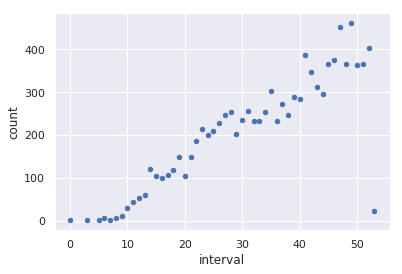

In [97]:
pyspark_time_pd.plot.scatter(x='interval', y='count')

In [98]:
pyspark_time_pd.corr()

,interval,count
interval,1.000000,0.880143
count,0.880143,1.000000


Yes there is a positive correlation of 0.88 between number of questions posted on pyspark with the time. We can see from the plot that as the time passed, the popularity of pyspark has increased.
Also there is a single point in 53th interval which has number of questions quite low, this is because it is the last interval and it is truncated i.e. it does not contain the whole of 30 days.